# Experimental Signal Analysis: Simulation → Processing Pipeline

This notebook merges two workstreams into a single, reproducible workflow:

1. **Superparamagnetic nanoparticle & sensor simulation** + **VSM curve analysis**  
2. **Cytometer signal processing** (peak detection / overlap handling) and derived outputs

> Data files are expected in the project `data/` folder (or update the paths in the configuration cell).

## Structure
- Part A — VSM analysis + physical simulation
- Part B — Cytometer signal processing
- Part C — (Optional) TensorFlow extension (to be added)

# Simulation and Experimental Analysis of Superparamagnetic Particle Detection

This notebook analyzes how **superparamagnetic particles** are detected using **magnetic sensors** embedded in a microfluidic channel.

The workflow combines:
- **Magnetic characterization** of particles (from VSM data),
- **Physical modeling** of magnetic fringe fields,
- **Electrical response modeling** of magnetoresistive sensors,
- **Experimental signal fitting** from a flow cytometer.

The goal is to **connect physics-based models to real experimental signals**, extracting physically meaningful parameters such as:
- particle height in the channel,
- magnetic moment orientation,
- signal overlap from multiple particles.


## Table of contents
- **0. Configuration & imports**
- **Part A — VSM curve analysis**
  - Data loading and normalization
  - Susceptibility estimation
  - Langevin fit (Ms, χ)
- **Part B — Field and sensor-response simulation**
  - Fringe field (vertical / horizontal moment)
  - Spin-valve electrical response (parallel / perpendicular)
  - Dynamic detection setup (forces + fluid profile)
- **Part C — Cytometer time-series**
  - TXT→PKL cache
  - Peak windowing and overlap fitting
  - Best-fit reporting and plotting


## 0) Configuration

In [132]:
# ------------------------------------------------------------
# 0) Configuration
# ------------------------------------------------------------
# Update paths to match your local folder layout.
# Raw data can stay outside the repo; this notebook expects a `data/` folder.

import os
# ===== Paths =====
VSM_CSV_PATH = "data/MvH.xlsx"          # normalized M(H) data (Excel)
VSM_TXT_PATH = "data/Superparamagn_nanopart_VSM.txt"

# Cytometer / time-series data
PKL_DIR = "data/pkl_dfs"
os.makedirs(PKL_DIR, exist_ok=True)
N_PKL = 59                 # number of pickle files to load

# General
RANDOM_SEED = 42


## 1) Imports

In [133]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from collections import defaultdict

from scipy.optimize import curve_fit
from mpmath import mp


## Part A — VSM analysis + simulation

### Importing data for experimental values

In [134]:
MvH_df = pd.read_excel(VSM_CSV_PATH,decimal=",")
#MvH_df

### Experimental data treatment and analysis

#### Comparison: non normalized with normalized curves

In [135]:
#Variables set to plot experimental VSM graphics

v_sample=0.05 #ml
n_sample=6*10**(8)                  #particles/ml
N_sample=n_sample*v_sample          #particles
Hext_exp=MvH_df.H_ext               #External field column from csv
H_fit=(Hext_exp*10**(3))/(4*(math.pi)) #SI units
M_Norm_exp=MvH_df.M_Norm
M_nNorm_exp=MvH_df.M_notnorm
Ms_Norm=np.amax(M_Norm_exp)
Ms_Norm1=(np.amax(M_Norm_exp)*10**(-3))/N_sample    #SI and per part
M_Norm_ppart_SI=(M_Norm_exp*10**-3)/N_sample
mp_norm=Ms_Norm1                                    #magnetic moment of each particle

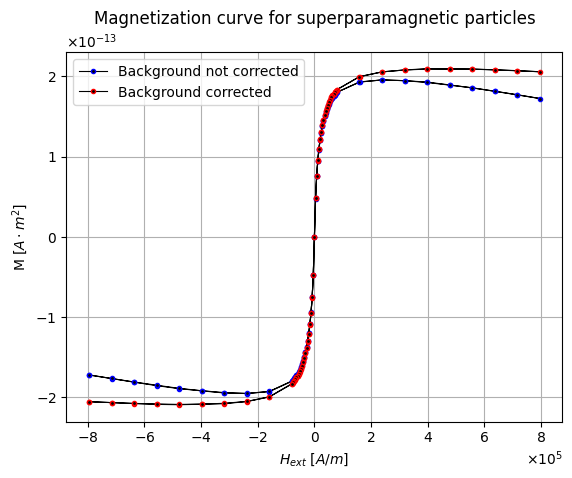

In [136]:
plt.plot(H_fit,M_nNorm_exp*10**(-3)/N_sample,ls='-',color="black",lw='0.8',marker='.',markeredgecolor='blue',label='Background not corrected')
plt.plot(H_fit,M_Norm_exp*10**(-3)/N_sample,ls='-',color="black",lw='0.8',marker='.',markeredgecolor='red',label='Background corrected')
plt.title("Magnetization curve for superparamagnetic particles")
plt.xlabel('$H_{ext}$ [$A/m$]')
plt.ylabel(r'M [$A \cdot m^2$]')
plt.grid()
plt.legend()
plt.ticklabel_format(style = 'sci', axis='both', scilimits=(0,0),useMathText=True)
#plt.savefig("Imagens_Latex\VSM.png")
plt.show()

#### Susceptibility: fitting and calculation

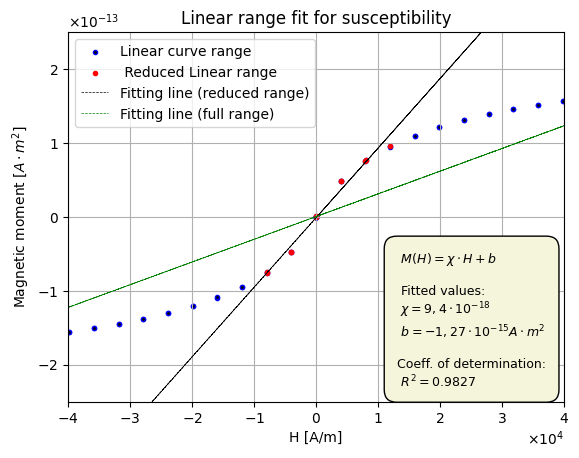

In [137]:
# Linear regime ranging from -2000<H<2000, roughly
def lin(x,a,b):
    return a*x + b

MxH_nlin=np.zeros((90,90))
MxH_nlin[0][0:41]=H_fit[9:50]
MxH_nlin[0][50:89]=H_fit[68:107]
MxH_nlin[1][0:41]=M_Norm_ppart_SI[9:50]
MxH_nlin[1][50:89]=M_Norm_ppart_SI[68:107]

MxH_lin=np.zeros((12,12))
MxH_lin[0][0:5]=H_fit[27:32]
MxH_lin[0][6:12]=H_fit[84:90]
MxH_lin[1][0:5]=M_Norm_ppart_SI[27:32]
MxH_lin[1][6:12]=M_Norm_ppart_SI[84:90]

plt.scatter(MxH_nlin[0],MxH_nlin[1],color="black",marker='.',edgecolor='blue',label='Linear curve range')
plt.scatter(MxH_lin[0],MxH_lin[1],color="red",marker='.',edgecolor='red',label=' Reduced Linear range')
plt.text(x=13000,y=-2.3*10**(-13),s=' $M(H)=\\chi \\cdot H + b $ \n  \n Fitted values: \n $ \\chi=9,4 \\cdot 10^{-18} $ \n $b= -1,27 \\cdot 10^{-15} A \\cdot m^2$ \n\nCoeff. of determination:\n $R^2=0.9827$'
         , bbox = dict(facecolor = 'beige', alpha = 1,edgecolor='black',boxstyle='round',pad=1),fontsize=9)
plt.xlabel('H [A/m]')
plt.ylabel(r'Magnetic moment $[A \cdot m^2]$')

popt_red,pcov_red = curve_fit(f=lin,xdata=MxH_lin[0],ydata=MxH_lin[1],p0=[4.8*10**(-6),0])
plt.plot(MxH_nlin[0],lin(MxH_nlin[0],popt_red[0],popt_red[1]),ls='--',lw='0.5',marker=' ',color='black'
         ,label='Fitting line (reduced range)')

popt_nred,pcov_nred = curve_fit(f=lin,xdata=MxH_nlin[0],ydata=MxH_nlin[1],p0=[4.8*10**(-6),0])
plt.plot(MxH_nlin[0],lin(MxH_nlin[0],popt_nred[0],popt_nred[1]),ls='--',lw='0.5',marker=' ',color='green'
         ,label='Fitting line (full range)')
Chi_sample=popt_red[0]


residuals = MxH_lin[1]- lin(MxH_lin[0], *popt_red)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((MxH_lin[1]-np.mean(MxH_lin[1]))**2)
r_squared = 1 - (ss_res / ss_tot)

plt.xlim([-40000,40000])
plt.ylim([-2.5*10**(-13),2.5*10**(-13)])
plt.ticklabel_format(style = 'sci', axis='both', scilimits=(0,0),useMathText=True)
plt.legend()
plt.grid()
plt.title("Linear range fit for susceptibility")
#plt.savefig("Imagens_Latex\Susceptibility.png")
plt.show()

## Fitting the VSM curve to get relevant parameters (Langevin function)

### Magnetization (Langevin model)

The magnetization of a superparamagnetic particle follows the **Langevin model**, which describes
materials with no hysteresis or remanence.

The magnetization is given by:
$$
M(H) = M_s \left( \coth(\lambda) - \frac{1}{\lambda} \right),
\qquad
\lambda = \frac{3 \chi N_{\text{beads}}}{M_s} \, H
$$

- $M_s$: saturation magnetization  
- $\chi$: susceptibility  
- $H$: applied field  


This model is fitted to experimental VSM data to extract **single-particle magnetic parameters**.

In [138]:
#defining coth
def coth(x):
    return 1.0 / np.tanh(x)

def func(H, Ms, Chi):
    # Accept scalar / numpy array / pandas Series
    H_arr = np.asarray(H, dtype=float)

    # Langevin argument (matches your figure): lambda = (3*Chi/Ms)*H
    lam = (3.0 * Chi / Ms) * H_arr

    # Numerical safety: avoid division by zero
    eps = 1e-12
    lam_safe = np.where(lam == 0, eps, lam)

    out = Ms * (coth(lam_safe) - 1.0 / lam_safe)

    # Enforce exact limit at lam = 0 -> 0
    out = np.where(lam == 0, 0.0, out)

    # Optional overflow guard (keeps your original intent)
    out = np.where(np.abs(lam) > 700, Ms * np.sign(lam), out)

    # Return scalar if scalar input
    return out.item() if np.isscalar(H) else out


#### Initial guess and universal constant sets:
##### Constants and initial guesses

In [139]:
#Saturating Magnetic moment 
PMs0=Ms_Norm*(10**(-3))
#Nparray of initial guesses    Xl=3chiH/Ms
PChi0=Chi_sample*N_sample
Ini_guess=[PMs0,PChi0]

##### Fitting VSM curve

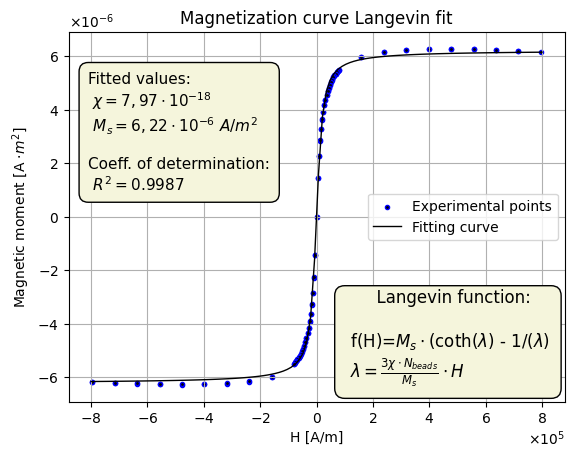

R^2: 0.9987


In [140]:
popt,pcov = curve_fit(f=func,xdata=H_fit,ydata=M_Norm_exp*10**(-3),p0=Ini_guess,maxfev=10000)
PMs=popt[0]
PChi=popt[1]
plt.scatter(H_fit,M_Norm_exp*10**(-3),color="black",marker='.',edgecolor='blue',label='Experimental points')
plt.grid()
xdummy=np.linspace(-800000,800000,116)
plt.plot(xdummy,func(xdummy,PMs,PChi),ls='-',lw='1',marker=' ',color='black'
         ,label='Fitting curve')
plt.xlabel('H [A/m]')
plt.ylabel(r'Magnetic moment [A $\cdot m^2$]')
plt.text(x=100000,y=-6.0*10**(-6),s='      Langevin function: \n \n f(H)=$M_s \\cdot$(coth($\\lambda$) - $1/(\\lambda)$ \n $\\lambda =\\frac{3 \\chi \\cdot N_{beads}}{M_s}\\cdot H $'
         , bbox = dict(facecolor = 'beige', alpha = 1,edgecolor='black',boxstyle='round',pad=0.6),fontsize=12)
plt.text(x=-810000,y=10**(-6),s='Fitted values: \n $ \\chi=7,97 \\cdot 10^{-18} $ \n $M_s= 6,22 \\cdot 10^{-6}$ $A/m^2$ \n\nCoeff. of determination:\n $R^2=0.9987$'
         , bbox = dict(facecolor = 'beige', alpha = 1,edgecolor='black',boxstyle='round',pad=0.6),fontsize=11)
plt.ticklabel_format(style = 'sci', axis='both', scilimits=(0,0),useMathText=True)
plt.legend()

residuals = M_Norm_exp*10**(-3)- func(H_fit, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((M_Norm_exp*10**(-3)-np.mean(M_Norm_exp*10**(-3)))**2)
r_squared = 1 - (ss_res / ss_tot)


plt.title("Magnetization curve Langevin fit")
#plt.savefig("Imagens_Latex\Langevin_fit.png")
plt.show()
print('R^2:',f'{r_squared:.4}')

### Simulating fringe field for the beads

#### Relevant parameters and function definition

In [141]:
d1=3*10**(-6)
d2=7*10**(-6)
d3=10*10**(-6)

def Havg(yp,zp,my,mz):
    h=zp
    xp=0
    l=98*10**(-6)
    w=2*10**(-6)
    xl=-l/2 -xp
    xr=l/2-xp
    yb=-w/2-yp
    yt=w/2-yp
    r1=(xl**2 + yb**2 + h**2)**(0.5)
    r2=(xr**2 + yb**2 + h**2)**(0.5)
    r3=(xr**2 + yt**2 + h**2)**(0.5)
    r4=(xl**2 + yt**2 + h**2)**(0.5)
    q1=(xl**2 + h**2)**(0.5)
    q2=(yb**2 + h**2)**(0.5)
    q3=(xr**2 + h**2)**(0.5)
    q4=(yt**2 + h**2)**(0.5)
    return (1/(4*np.pi))*(my/(l*w))*( (yb/q2**2)*(xr/r2 - xl/r1) + (yt/q4**2)*(xl/r4 - xr/r3)) + (1/(4*np.pi))*(mz/(l*w))*((h/q2**2)*(xl/r1 - xr/r2) +(h/q4**2)*(xr/r3 - xl/r4))

#### Fringe field created by vertical moment bead

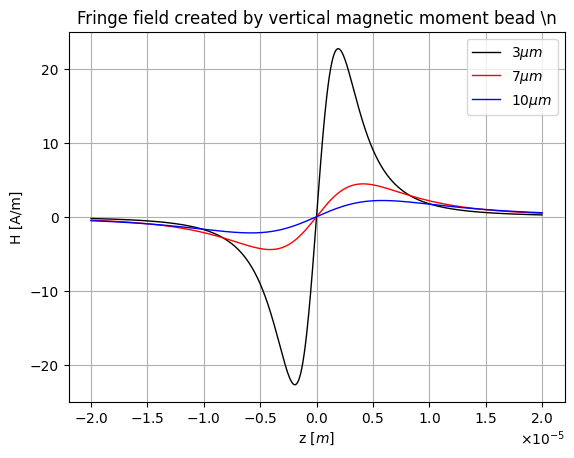

In [142]:
x=np.linspace(-20*10**(-6),20*10**(-6),1000)
plt.plot(x,Havg(x,d1,mz=mp_norm,my=0),ls='-',color="black",lw='1',marker='',markeredgecolor='blue',label='$ 3\\mu m$')
plt.plot(x,Havg(x,d2,mz=mp_norm,my=0),ls='-',color="red",lw='1',marker='',markeredgecolor='blue',label='$ 7\\mu m$')
plt.plot(x,Havg(x,d3,mz=mp_norm,my=0),ls='-',color="blue",lw='1',marker='',markeredgecolor='blue',label='$ 10\\mu m$')
plt.ticklabel_format(style = 'sci', axis='x', scilimits=(0,0),useMathText=True)
plt.title(r"Fringe field created by vertical magnetic moment bead \n")
plt.xlabel('z [$m$]')
plt.ylabel('H [A/m]')
plt.legend()
plt.grid()
plt.show()

#### Fringe field created by horizontal moment bead

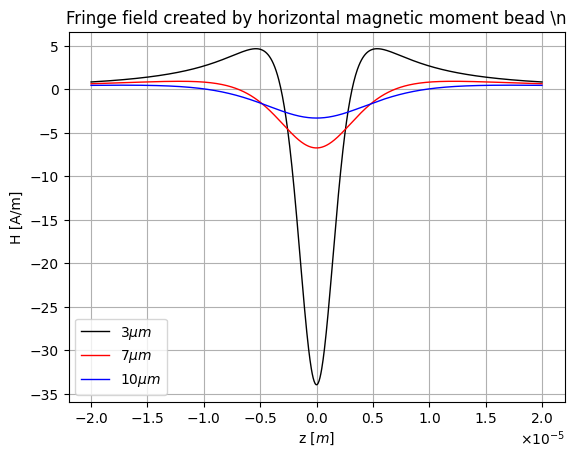

In [143]:
plt.plot(x,Havg(x,d1,my=mp_norm,mz=0),ls='-',color="black",lw='1',marker='',markeredgecolor='blue',label='$ 3\\mu m$')
plt.plot(x,Havg(x,d2,my=mp_norm,mz=0),ls='-',color="red",lw='1',marker='',markeredgecolor='blue',label='$ 7\\mu m$')
plt.plot(x,Havg(x,d3,my=mp_norm,mz=0),ls='-',color="blue",lw='1',marker='',markeredgecolor='blue',label='$ 10\\mu m$')
plt.ticklabel_format(style = 'sci', axis='x', scilimits=(0,0),useMathText=True)
plt.xlabel('z [$m$]')
plt.ylabel('H [A/m]')
plt.title(r"Fringe field created by horizontal magnetic moment bead \n")
plt.legend()
plt.grid()
#plt.savefig("Imagens_Latex\Langevin_fit2.png")
plt.show()

### Simulating sensor response (Spin Valve)

#### Sensor and beads parameters:

In [144]:
#Relevant parameters for the sensor (GMR sensor dimensions: h=2.3mu m,w=98mu m,)
Ss=(4*np.pi*2.47*10**(-7) )
Rmin=3990.937
Ibias=10**(-3)

def Vper(x,d):
    return Ss*Rmin*Ibias*Havg(x,d,mz=mp_norm,my=0)
def Vpar(x,d):
    return Ss*Rmin*Ibias*Havg(x,d,my=mp_norm,mz=0)

#### Perpendicular B_ext

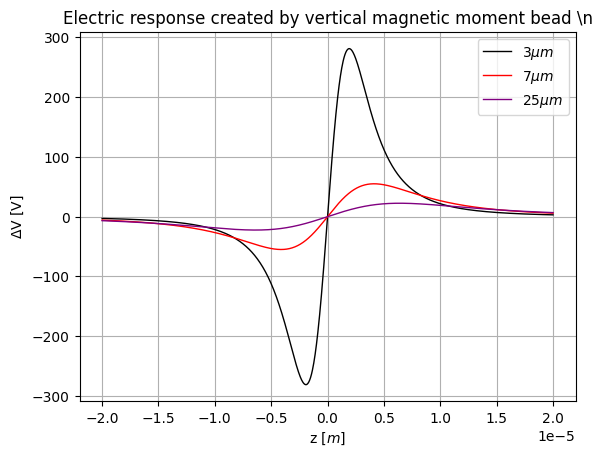

20.535592523277078


In [145]:
plt.plot(x,Vper(x,d1)/10**-6,ls='-',color="black",lw='1',marker='',markeredgecolor='blue',label='$3 \\mu m$')
plt.plot(x,Vper(x,d2)/10**-6,ls='-',color="red",lw='1',marker='',markeredgecolor='blue',label='$7 \\mu m$')
plt.plot(x,Vper(x,11*10**-6)/10**-6,ls='-',color="purple",lw='1',marker='',markeredgecolor='blue',label='$25 \\mu m$')
plt.title(r"Electric response created by vertical magnetic moment bead \n")
plt.xlabel('z [$m$]')
plt.ylabel(r'$\Delta$V [V]')
#plt.ticklabel_format(style = 'sci', axis='both', scilimits=(0,0),useMathText=True)
plt.grid()
plt.legend()
plt.show()
print(np.max(Vper(x,11.5*10**-6)/10**-6))

#### Parallel B_ext

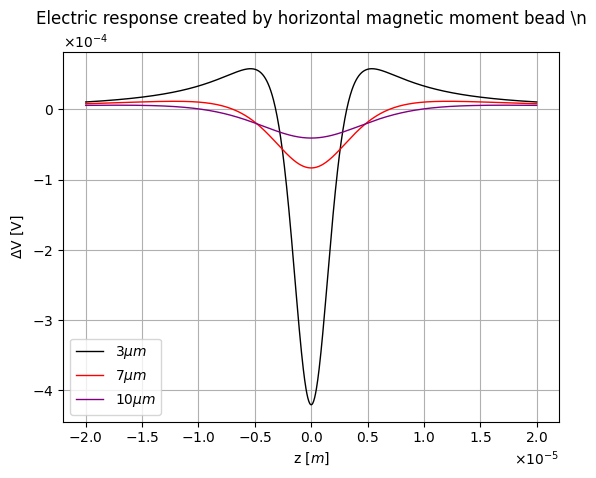

In [146]:
plt.plot(x,Vpar(x,d1),ls='-',color="black",lw='1',marker='',markeredgecolor='blue',label='$3 \\mu m$')
plt.plot(x,Vpar(x,d2),ls='-',color="red",lw='1',marker='',markeredgecolor='blue',label='$7 \\mu m$')
plt.plot(x,Vpar(x,d3),ls='-',color="purple",lw='1',marker='',markeredgecolor='blue',label='$10 \\mu m$')
plt.title(r"Electric response created by horizontal magnetic moment bead \n")
plt.xlabel('z [$m$]')
plt.ylabel(r'$\Delta$V [V]')
plt.ticklabel_format(style = 'sci', axis='both', scilimits=(0,0),useMathText=True)
plt.grid()
plt.legend()
plt.show()

# Dynamic detection simulation (forces and fluid)

## 6.1 Magnetic fields:

### 6.1.1 Magnetic field created by a conductor for MAGNETOPHORESIS
#### This means only the attraction/repulsive forces are considered

In [147]:
def Hx(y):
    zc0=-0.25*10**(-6)
    zcf=0.25*10**(-6)
    xc0=-(2)*10**(-6)
    xcf=2*10**(-6)
    yc0=-(3.5)*10**(-6)
    ycf=(3.5)*10**(-6)
    I=25*10**(-3)
    A=(zcf-zc0)*(xcf-xc0)
    rx=0
    rz=2*10**(-6)-zc0 #dz/dt=0
    ry=y #y -20 +20 um
    r=(rz**2 + rx**2 + ry**2 )**(1/2)
    C1=yc0*(np.arctan(zc0/yc0)+ np.arctan((xc0*zc0)/(r*yc0)))-ycf*(np.arctan(zcf/ycf)+ np.arctan((xcf*zcf)/(r*ycf)))
    C2=zcf*(1-np.log(r-xcf)) -xcf*(np.log(r-zcf)) - zc0*(1-np.log(r-xc0)) +xc0*(np.log(r-zc0))
    return (I/(4*np.pi*A))*(C1+C2)

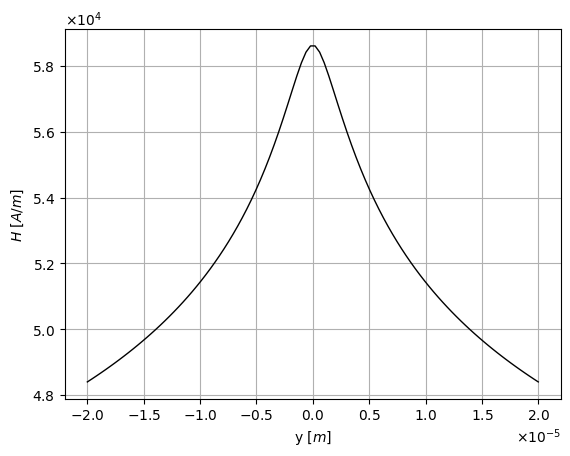

In [148]:
d4=2*10**(-6)
xmagn=np.linspace(-20*10**(-6),20*10**(-6),100)
plt.plot(xmagn,Hx(xmagn),ls='-',color="black",lw='1',marker='',markeredgecolor='blue',label='$3 \\mu m$')
plt.xlabel('y [$m$]')
plt.ylabel('$H$ [$A/m$]')
plt.ticklabel_format(style = 'sci', axis='both', scilimits=(0,0),useMathText=True)
plt.grid()
plt.show()

In [149]:
def der(x,y):
    yprime=np.diff(y)/np.diff(x)
    xprime=[]
    for i in range(len(yprime)):
        xtemp=(x[i+1]-x[i])/2
        xprime=np.append(xprime,xtemp)
    return xprime,yprime

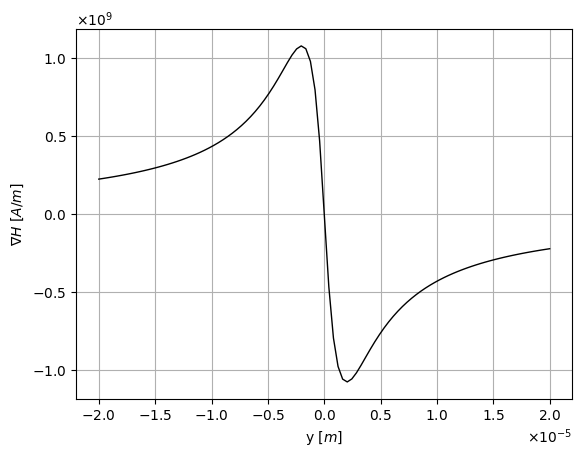

In [150]:
xmagn2=np.linspace(-20*10**(-6),20*10**(-6),99)
plt.plot(xmagn2,der(xmagn,Hx(xmagn))[1],ls='-',color="black",lw='1',marker='',markeredgecolor='blue',label='')
plt.xlabel('y [$m$]')
plt.ylabel(r'$\nabla H$ [$A/m$]')
plt.ticklabel_format(style = 'sci', axis='both', scilimits=(0,0),useMathText=True)
plt.grid()
plt.show()

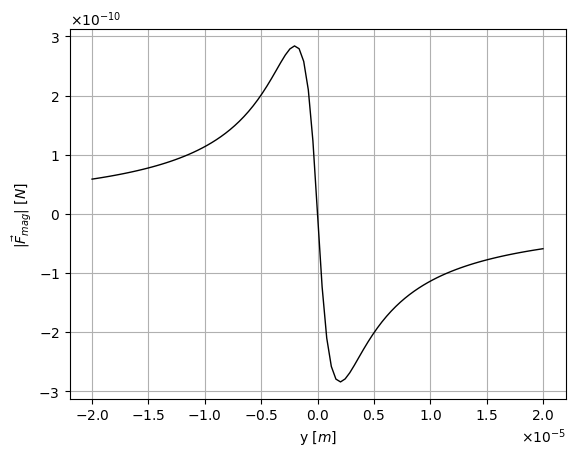

In [151]:
F=der(xmagn,Hx(xmagn))[1]*4*np.pi*mp_norm*10**(-7)
plt.plot(xmagn2,F,ls='-',color="black",lw='1',marker='',markeredgecolor='blue',label='')
plt.xlabel('y [$m$]')
plt.ylabel(r'$|\vec{F}_{mag}|$ [$N$]')
plt.ticklabel_format(style = 'sci', axis='both', scilimits=(0,0),useMathText=True)
plt.grid()
plt.show()

# Fluid dynamics

## Velocity profile (laminar flow)

Assuming laminar Poiseuille flow in a microchannel, the velocity across height $z$ is parabolic:

$$
v(z) = A\,z(z-h)
$$

- $h$: channel height  
- $A$: fitted constant  


### &rarr;Mathematical approach

#### We know that the profile is a parabolic function on the approximation. If we use the no-slip condition, then all we have to do is use three points: both no slip (z=0 and z=h) as well as vmax=400um: y=a*(x-h1)*(x-h2), where h1 and h2 are the roots of the parabola, (z=0,h).   y=a*(x-h1)*(x-h2), where h1 and h2 are the roots of the parabola, (z=0,h).
#### Calculating a, using vmax=400mu and x=7um (=h/2):

In [152]:
h=14*10**(-6)
v_fluid=4*10**(-7)
a=(v_fluid)/((h/2-0)*(h/2-h))

def x(v,t):
    return -20*10**(-6)+ v*t

def v_profile(z):
    return a*z*(z-h)


t=np.linspace(0,150,2000)
xd1= x(v_profile(d1),t)
xd2= x(v_profile(d2),t)
xd3= x(v_profile(d3),t)
roots=[74.4,50,61.3]
Voltage=[0.0,0.0,0.0]

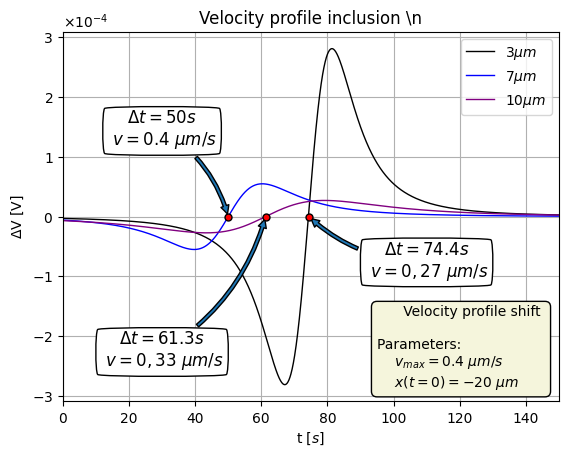

In [153]:
#X=t, Y=Signal
plt.plot(t,Vper(xd1,d1),ls='-',color="black",lw='1',marker='',markeredgecolor='blue',label='$3 \\mu m$')
plt.plot(t,Vper(xd2,d2),ls='-',color="blue",lw='1',marker='',markeredgecolor='blue',label='$7 \\mu m$')
plt.plot(t,Vper(xd3,d3),ls='-',color="purple",lw='1',marker='',markeredgecolor='blue',label='$10 \\mu m$')
plt.scatter(roots,Voltage,color="red",marker='.',edgecolor='black',s=100,zorder=10)
plt.ticklabel_format(style = 'sci', axis='y', scilimits=(0,0),useMathText=True)
plt.title(r"Velocity profile inclusion \n")
plt.xlabel('t [$s$]')
plt.ylabel(r'$\Delta$V [V]')
plt.xlim(0,150)
plt.text(x=95,y=-2.84*10**(-4),s='      Velocity profile shift \n \nParameters: \n    $v_{max}=0.4$ $ \\mu m/s$ \n    $x(t=0) = -20$ $ \\mu m$'
         , bbox = dict(facecolor = 'beige', alpha = 1,edgecolor='black',boxstyle='round',pad=0.4),fontsize=10)
plt.annotate('$\\Delta t=74.4s$\n $v =0,27$ $ \\mu m/s$'
             ,(74.4,0),xytext=(110,-1*10**(-4)),size=12,bbox=dict(boxstyle="round4", fc="w"),arrowprops=dict(arrowstyle="simple",
                            connectionstyle="arc3,rad=-0.2"),    
                ha='center')
plt.annotate('$\\Delta t=50s$ \n $v =0.4$ $ \\mu m/s$'
             ,(50,0),xytext=(30,1.2*10**(-4)),size=12,bbox=dict(boxstyle="round4", fc="w"),arrowprops=dict(arrowstyle="simple",
                            connectionstyle="arc3,rad=-0.2"),    
                ha='center')
plt.annotate('$\\Delta t=61.3s$\n $v =0,33$ $ \\mu m/s$'
             ,(61.3,0),xytext=(30,-2.5*10**(-4)),size=12,bbox=dict(boxstyle="round4", fc="w"),arrowprops=dict(arrowstyle="simple",
                            connectionstyle="arc3,rad=0.2"),    
                ha='center')
plt.grid()
plt.legend()
plt.show()

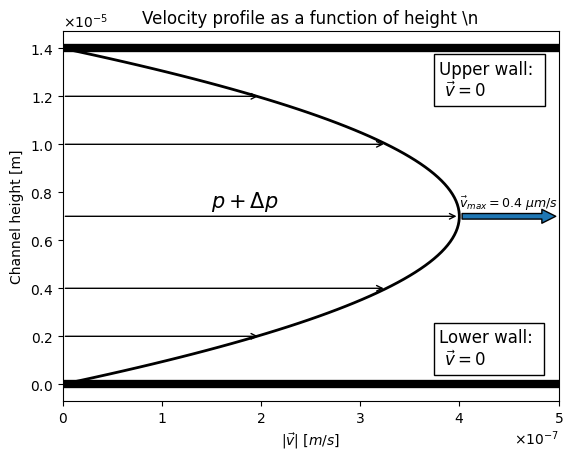

In [154]:
alt=np.linspace(0,14*10**(-6),100)
platesx=np.linspace(0,5*10**-7,10)
platey0=np.linspace(0,0,10)
platey1=np.linspace(1.4*10**-5,1.4*10**-5,10)
plt.plot(platesx,platey0,ls='-',lw='6',marker=' ',color='black')
plt.plot(platesx,platey1,ls='-',lw='6',marker=' ',color='black')
plt.plot(v_profile(alt),alt,ls='-',lw='2',marker=' ',color='black')
plt.plot(0,1.4*10**(-5),ls='-',lw='1',marker=' ',color='black')
plt.ticklabel_format(style = 'sci', axis='both', scilimits=(0,0),useMathText=True)
plt.title(r"Velocity profile as a function of height \n")
plt.xlabel(r'|$\vec{v}$| [$m/s$]')
plt.ylabel('Channel height [m]')
plt.annotate('',(4*10**(-7),7*10**(-6)),xytext=(0,7*10**(-6)),size=10,arrowprops=dict(facecolor="black",arrowstyle='->'),ha='center')
plt.annotate('',(2*10**(-7),12*10**(-6)),xytext=(0,12*10**(-6)),size=10,arrowprops=dict(facecolor="black",arrowstyle='->'),ha='center')
plt.annotate('',(2*10**(-7),2*10**(-6)),xytext=(0,2*10**(-6)),size=10,arrowprops=dict(facecolor="black",arrowstyle='->'),ha='center')
plt.annotate('',(5*10**(-7),7*10**(-6)),xytext=(4*10**(-7),7*10**(-6)),size=20,arrowprops=dict(arrowstyle="simple"),ha='center')
plt.xlim(0,5*10**-7)
plt.annotate('',(3.2653*10**(-7),10*10**(-6)),xytext=(0,10*10**(-6)),size=10,arrowprops=dict(facecolor="black",arrowstyle='->'),ha='center')
plt.annotate('',(3.2653*10**(-7),4*10**(-6)),xytext=(0,4*10**(-6)),size=10,arrowprops=dict(facecolor="black",arrowstyle='->'),ha='center')
plt.text(3.8*10**(-7),12*10**(-6),'Upper wall: \n $\\vec{v}=0$',fontsize=12,bbox=dict( fc="w"))
plt.text(3.8*10**(-7),0.8*10**(-6),'Lower wall: \n $\\vec{v}=0$',fontsize=12,bbox=dict( fc="w"))
plt.text(4*10**(-7),7.4*10**(-6),'$\\vec{v}_{max}=0.4 $ $\\mu m/s$',fontsize=9)
plt.text(1.5*10**(-7),7.4*10**(-6),'$p + \\Delta p$',fontsize=15)
#plt.grid()
plt.show()

# Field and Signal created by rotated particles:

## We now have to redefine our function to include the angle, having both my and mz

In [155]:
def Hrot(yp,zp,Ms_part,theta): 
    h=zp
    xp=0
    l=98*10**(-6)
    w=2*10**(-6)
    mz=Ms_part*(math.cos(theta))
    my=Ms_part*(math.sin(theta))
    xl=-l/2 -xp
    xr=l/2-xp
    yb=-w/2-yp
    yt=w/2-yp
    r1=(xl**2 + yb**2 + h**2)**(0.5)
    r2=(xr**2 + yb**2 + h**2)**(0.5)
    r3=(xr**2 + yt**2 + h**2)**(0.5)
    r4=(xl**2 + yt**2 + h**2)**(0.5)
    q1=(xl**2 + h**2)**(0.5)
    q2=(yb**2 + h**2)**(0.5)
    q3=(xr**2 + h**2)**(0.5)
    q4=(yt**2 + h**2)**(0.5)
    return (1/(4*np.pi))*(my/(l*w))*( (yb/q2**2)*(xr/r2 - xl/r1) + (yt/q4**2)*(xl/r4 - xr/r3)) + (1/(4*np.pi))*(mz/(l*w))*((h/q2**2)*(xl/r1 - xr/r2) +(h/q4**2)*(xr/r3 - xl/r4))

### Field created by rotated particle

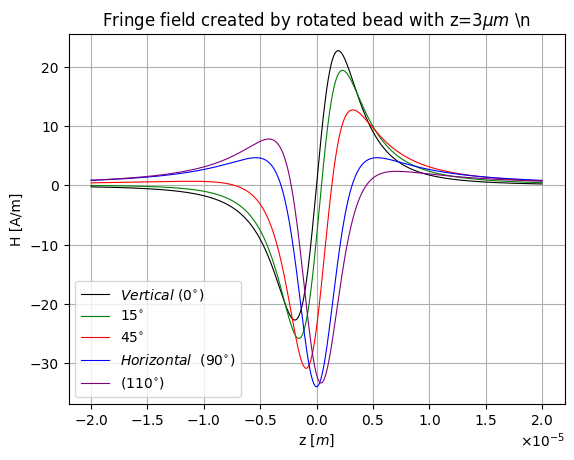

In [156]:
x=np.linspace(-20*10**(-6),20*10**(-6),1000)
plt.plot(x,Hrot(x,d1,mp_norm,0),ls='-',color="black",lw='0.8',marker='',markeredgecolor='blue',label='$Vertical$ $(0^{\\circ})$')
plt.plot(x,Hrot(x,d1,mp_norm,0.261799388),ls='-',color="green",lw='0.8',marker='',markeredgecolor='blue',label='$ 15^{\\circ}$')
plt.plot(x,Hrot(x,d1,mp_norm,np.pi/4),ls='-',color="red",lw='0.8',marker='',markeredgecolor='blue',label='$ 45^{\\circ}$')
plt.plot(x,Hrot(x,d1,mp_norm,np.pi/2),ls='-',color="blue",lw='0.8',marker='',markeredgecolor='blue',label='$Horizontal$  $(90^{\\circ})$')
plt.plot(x,Hrot(x,d1,mp_norm,(11*np.pi)/18),ls='-',color="purple",lw='0.8',marker='',markeredgecolor='purple',label='$(110^{\\circ})$')
#plt.plot(x,Hrot(x,d1,mp_norm,pi),ls='-',color="crimson",lw='1.5',marker='',markeredgecolor='purple',label='$(180^{\circ})$')
plt.ticklabel_format(style = 'sci', axis='x', scilimits=(0,0),useMathText=True)
plt.title(r"Fringe field created by rotated bead with z=$3 \mu m$ \n")
plt.xlabel('z [$m$]')
plt.ylabel('H [A/m]')
plt.legend()
plt.grid()
#plt.savefig("Imagens_Latex\H_rot.png")
plt.show()

### Electric signal of the rotated particle

In [157]:
def Vrot(x,d,theta):
    return Ss*Rmin*Ibias*Hrot(x,d,mp_norm,theta)

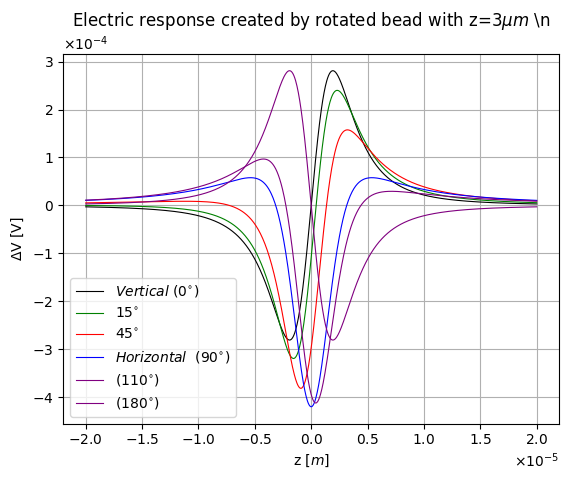

In [158]:
plt.plot(x,Vrot(x,d1,0),ls='-',color="black",lw='0.8',marker='',markeredgecolor='blue',label='$Vertical$ $(0^{\\circ})$')
plt.plot(x,Vrot(x,d1,0.261799388),ls='-',color="green",lw='0.8',marker='',markeredgecolor='blue',label='$ 15^{\\circ}$')
plt.plot(x,Vrot(x,d1,np.pi/4),ls='-',color="red",lw='0.8',marker='',markeredgecolor='blue',label='$ 45^{\\circ}$')
plt.plot(x,Vrot(x,d1,np.pi/2),ls='-',color="blue",lw='0.8',marker='',markeredgecolor='blue',label='$Horizontal$  $(90^{\\circ})$')
plt.plot(x,Vrot(x,d1,(11*np.pi)/18),ls='-',color="purple",lw='0.8',marker='',markeredgecolor='purple',label='$(110^{\\circ})$')
plt.plot(x,Vrot(x,d1,np.pi),ls='-',color="purple",lw='0.8',marker='',markeredgecolor='purple',label='$(180^{\\circ})$')
plt.ticklabel_format(style = 'sci', axis='BOTH', scilimits=(0,0),useMathText=True)
plt.title(r"Electric response created by rotated bead with z=$3 \mu m$ \n")
plt.xlabel('z [$m$]')
plt.ylabel(r'$\Delta$V [V]')
plt.legend()
plt.grid()
#plt.savefig("Imagens_Latex\V_rot.png")
plt.show()

## Part B — Cytometer signal processing

### 1) How the particle velocity is estimated
The cytometer data provides voltage signals as a function of **time**.  
To compare the experimental peak with a physics model (which is naturally expressed versus **position** along the sensor), we need a way to convert time → distance.

The approach used here is a **peak-timing method**:

- Each particle passing over the sensor produces a characteristic peak in the signal.
- The peak has two key extrema (a maximum and a minimum).  
- The **time difference** between these extrema, Δt, corresponds to the time the particle takes to travel a known fraction of the sensor region that produces the bipolar response.

Using a previously estimated average flow speed `vavg`, we compute a reference displacement associated with that peak:
- `dt = t_min - t_max`
- `d_origin_peak = vavg * dt / 2`

Then, the time axis is **re-centered around the peak** and scaled by `vavg` so that the signal is represented in a distance-like coordinate (more convenient for fitting the particle position in the model).

This does not require knowing the exact channel profile; it is a practical way to align experimental peaks to the modeled response.

### 2) Why multiple signals (channels) are analyzed together
The experiment records several sensor outputs at the same time (e.g., `ch1`, `ch2`, `ch3`, `ch4`).  
Analyzing multiple channels together is useful because each channel provides complementary information and helps validate the event:

- **Consistency check:** a real particle event should appear coherently across channels (timing alignment and expected polarity).
- **Noise rejection:** if a peak appears only in one channel, it is more likely an artifact.
- **Geometry/position sensitivity:** channels can respond differently depending on particle trajectory (height/lateral offset), so looking at multiple channels helps interpret the event and avoid overfitting one trace.
- **Robust fitting:** the chosen channel (often `ch1`) is used for parameter fitting, while the others help confirm the physical plausibility of the extracted parameters.

In short: velocity scaling makes the signal comparable to the spatial model, and multi-channel analysis increases confidence that the fitted event corresponds to a real particle transit rather than noise.

### First import directly by csv (takes a long time), so using pickle to store pandas dataframes, making the load process much faster and the files much smaller. Check for pkl files before reading .txt

In [159]:
import os
import glob
import pandas as pd

DATA_DIR = "data"
os.makedirs(DATA_DIR, exist_ok=True)

# Recursive search (handles subfolders)
txt_files = sorted(glob.glob(os.path.join(DATA_DIR, "**", "*.txt"), recursive=True))
pkl_files = glob.glob(os.path.join(DATA_DIR, "**", "*.pkl"), recursive=True)

def _numeric_stem(path):
    stem = os.path.splitext(os.path.basename(path))[0]
    return int(stem) if stem.isdigit() else float("inf")

# Sort PKLs numerically when possible (0.pkl, 1.pkl, ...)
pkl_files = sorted(pkl_files, key=_numeric_stem)

print(f"Found {len(txt_files)} TXT files.")
print(f"Found {len(pkl_files)} PKL files.")

dfs = []
dfspkl = []

if pkl_files:
    print("Loading pickles...")
    for pkl in pkl_files:
        df = pd.read_pickle(pkl)
        df.columns = ["t", "ch1", "ch2", "ch3", "ch4"]
        dfspkl.append(df)
else:
    print("No pickles found. Reading TXTs and saving PKLs...")
    for i, file in enumerate(txt_files):
        df = pd.read_csv(file, header=None, engine="python", sep="  ")
        dfs.append(df)

        out_path = os.path.join(DATA_DIR, f"{i}.pkl")
        df.to_pickle(out_path)

        df.columns = ["t", "ch1", "ch2", "ch3", "ch4"]
        dfspkl.append(df)

print(f"Loaded dfspkl with {len(dfspkl)} dataframes.")

Found 59 TXT files.
Found 59 PKL files.
Loading pickles...
Loaded dfspkl with 59 dataframes.


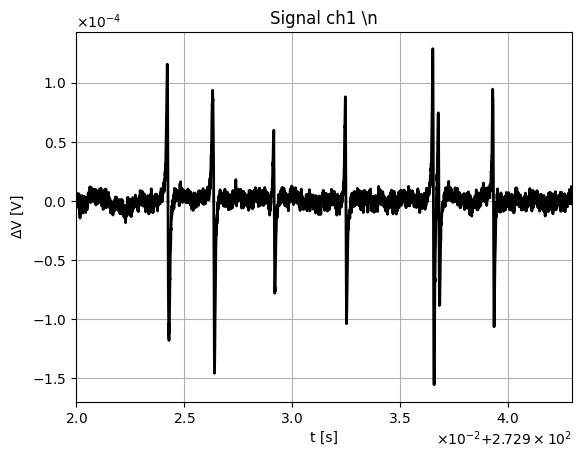

In [160]:
plt.plot(dfspkl[38]['t'],dfspkl[38]['ch1'],ls='-',color="black",lw='2',marker='',markeredgecolor='red')
plt.title(r"Signal ch1 \n")
plt.xlabel('t [s]')
plt.ylabel(r'$\Delta$V [V]')
plt.grid()
plt.ticklabel_format(style = 'sci', axis='both', scilimits=(0,0),useMathText=True)
plt.xlim([272.920,272.943])
plt.show()

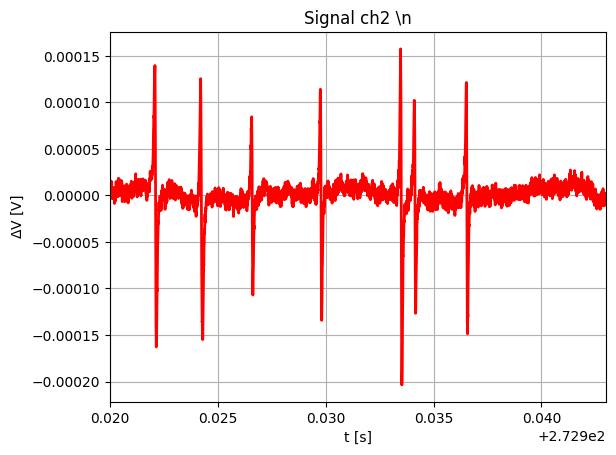

In [161]:
plt.plot(dfspkl[38]['t'],dfspkl[38]['ch2'],ls='-',color="red",lw='2',marker='',markeredgecolor='red')
plt.title(r"Signal ch2 \n")
plt.xlabel('t [s]')
plt.ylabel(r'$\Delta$V [V]')
plt.grid()
#plt.ticklabel_format(style = 'sci', axis='both', scilimits=(0,0),useMathText=True)
plt.xlim([272.920,272.943])
plt.show()

(272.92, 272.943)

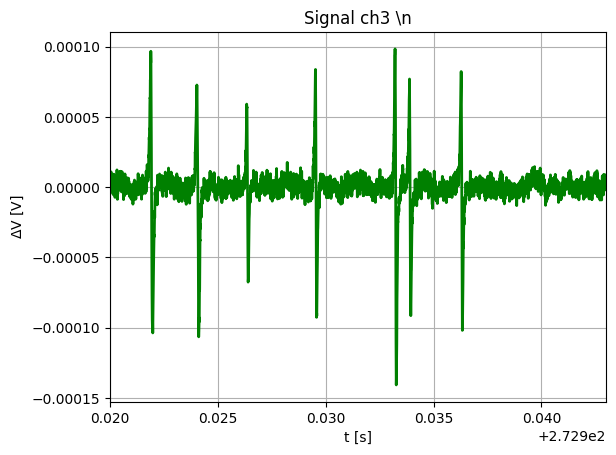

In [162]:
plt.plot(dfspkl[38]['t'],dfspkl[38]['ch3'],ls='-',color="green",lw='2',marker='',markeredgecolor='yellow')
plt.title(r"Signal ch3 \n")
plt.xlabel('t [s]')
plt.ylabel(r'$\Delta$V [V]')
plt.grid()
#plt.ticklabel_format(style = 'sci', axis='both', scilimits=(0,0),useMathText=True)
plt.xlim([272.920,272.943])

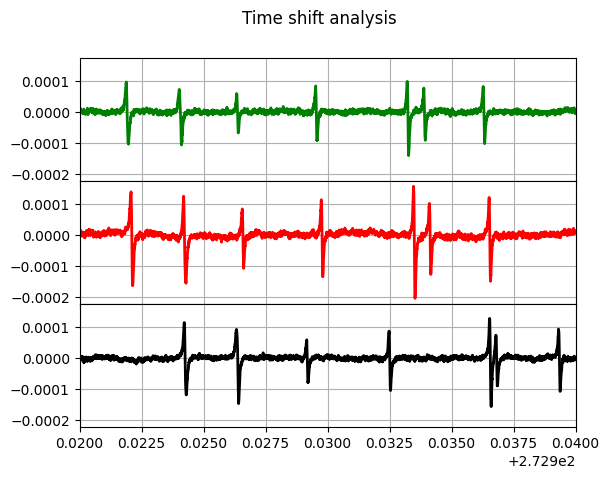

In [163]:
fig = plt.figure()
gs = fig.add_gridspec(3, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)
fig.suptitle('Time shift analysis')
axs[0].plot(dfspkl[38]['t'],dfspkl[38]['ch3'],ls='-',color="green",lw='2',marker='',markeredgecolor='yellow')
axs[0].grid()
axs[1].plot(dfspkl[38]['t'],dfspkl[38]['ch2'],ls='-',color="red",lw='2',marker='',markeredgecolor='red')
axs[1].grid()
axs[2].plot(dfspkl[38]['t'],dfspkl[38]['ch1'],ls='-',color="black",lw='2',marker='',markeredgecolor='red')
axs[2].grid()
axs[0].set_xlim([272.920,272.940])
for ax in axs:
    ax.label_outer()

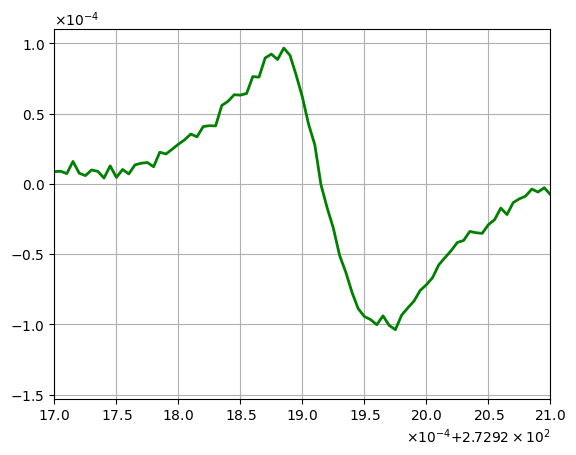

In [164]:
plt.plot(dfspkl[38]['t'],dfspkl[38]['ch3'],ls='-',color="green",lw='2',marker='',markeredgecolor='yellow')
plt.grid()
plt.xlim([272.9217,272.9221])
plt.ticklabel_format(style = 'sci', axis='both', scilimits=(0,0),useMathText=True)
plt.show()

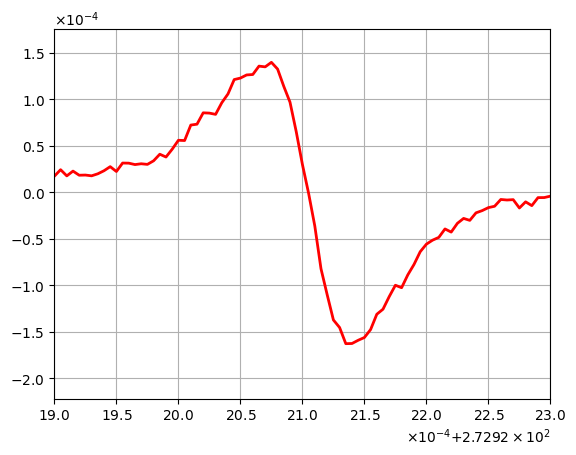

In [165]:
plt.plot(dfspkl[38]['t'],dfspkl[38]['ch2'],ls='-',color="red",lw='2',marker='',markeredgecolor='yellow')
plt.grid()
plt.xlim([272.9219,272.9223])
plt.ticklabel_format(style = 'sci', axis='both', scilimits=(0,0),useMathText=True)
plt.show()
t_ch2=272.9221

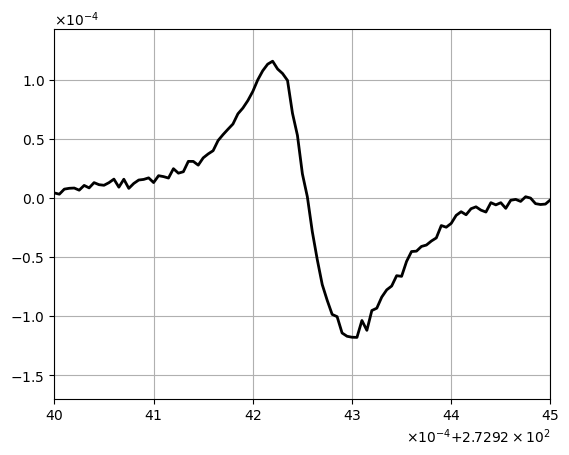

In [166]:
plt.plot(dfspkl[38]['t'],dfspkl[38]['ch1'],ls='-',color="black",lw='2',marker='',markeredgecolor='red')
plt.grid()
plt.xlim([272.9240,272.9245])
plt.ticklabel_format(style = 'sci', axis='both', scilimits=(0,0),useMathText=True)
plt.show()

In [167]:
df_shift_ch3 = dfspkl[38][ (dfspkl[38]['t'] >=272.9217) & (dfspkl[38]['t'] <= 272.9221)]
df_shift_ch3
df_center1=df_shift_ch3[ (df_shift_ch3['ch3'] >=0) ]
t_ch3=(272.9217+272.9221)/2 # aprox. half the interval
t_ch1=272.92425             # aprox. half the interval
dt=t_ch1-t_ch3
dch3_ch1=(90+60+30+15)*10**(-6)
vavg=dch3_ch1/dt
df_shift_ch1 = dfspkl[38][ (dfspkl[38]['t'] >=272.9240) & (dfspkl[38]['t'] <= 272.9245)]

# Distance between ch1 and ch2 SVs, for comparison
dx12=vavg*(t_ch2-t_ch3)

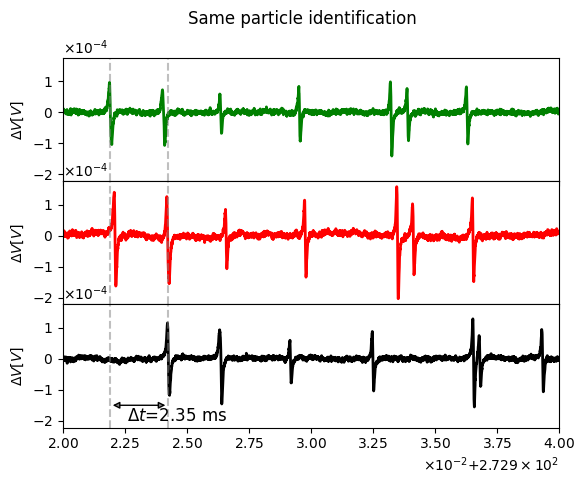

In [168]:
fig = plt.figure()
gs = fig.add_gridspec(3, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)
fig.suptitle('Same particle identification')
axs[0].plot(dfspkl[38]['t'],dfspkl[38]['ch3'],ls='-',color="green",lw='2',marker='',markeredgecolor='yellow')
axs[0].axvline(x = t_ch3, color = 'gray',ls='--',alpha=0.5)
axs[0].axvline(x =t_ch1, color = 'gray',ls='--',alpha=0.5)
axs[0].set(ylabel='$ \\Delta V [V]$')
axs[1].plot(dfspkl[38]['t'],dfspkl[38]['ch2'],ls='-',color="red",lw='2',marker='',markeredgecolor='red')
axs[1].axvline(x = t_ch3, color = 'gray',ls='--',alpha=0.5)
axs[1].axvline(x =t_ch1, color = 'gray',ls='--',alpha=0.5)
axs[1].set(ylabel='$ \\Delta V [V]$')
axs[2].plot(dfspkl[38]['t'],dfspkl[38]['ch1'],ls='-',color="black",lw='2',marker='',markeredgecolor='red')
axs[2].axvline(x = t_ch3, color = 'gray',ls='--',alpha=0.5)
axs[2].axvline(x =t_ch1, color = 'gray',ls='--',alpha=0.5)
axs[2].set(ylabel='$ \\Delta V [V]$')
axs[0].set_xlim([272.920,272.940])
plt.text(272.9226,-0.0002,'$\\Delta t$=2.35 ms',fontsize=12)
axs[2].annotate('',(t_ch3,-0.00015),xytext=(t_ch1,-0.00015),size=10,arrowprops=dict(facecolor="gray",arrowstyle='<|-|>',alpha=1),ha='center')
#axs[0].set_xlim([272.93,272.940])
plt.ticklabel_format(style = 'sci', axis='both', scilimits=(0,0),useMathText=True)
for ax in axs:
    ax.label_outer()
#plt.savefig("Imagens_Latex\part_ident.png")

In [169]:
# ---------------------------------------------------------------------
# Particle fringe-field model + sensor voltage response
# ---------------------------------------------------------------------

def Hrot(yp, zp, xp, theta):
    """
    Fringe-field contribution from a single rotated magnetic particle.

    Notes
    -----
    This implementation is NumPy-safe: `xp` may be a scalar or an array.

    Parameters
    ----------
    yp : float
        Particle lateral position along y (m).
    zp : float
        Particle height above the sensor plane (m).
    xp : float or np.ndarray
        Particle longitudinal position along x (m).
    theta : float
        Magnetic moment angle (rad).

    Returns
    -------
    float or np.ndarray
        Magnetic field contribution (same shape as `xp`).
    """
    # Geometry and constants
    h = zp
    l = 100e-6   # sensor length (m)
    w = 2e-6     # sensor width (m)
    mp = 2.0933333333333334e-13  # particle magnetic moment (A·m²)

    # Magnetic moment components
    my = mp * np.sin(theta)
    mz = mp * np.cos(theta)

    # Sensor edges relative to particle position
    xl = -l / 2 - xp
    xr =  l / 2 - xp
    yb = -w / 2 - yp
    yt =  w / 2 - yp

    # Distances to the four corners
    r1 = np.sqrt(xl**2 + yb**2 + h**2)
    r2 = np.sqrt(xr**2 + yb**2 + h**2)
    r3 = np.sqrt(xr**2 + yt**2 + h**2)
    r4 = np.sqrt(xl**2 + yt**2 + h**2)

    # Auxiliary distances (no x dependence)
    q2 = np.sqrt(yb**2 + h**2)
    q4 = np.sqrt(yt**2 + h**2)

    prefactor = 1.0 / (4.0 * np.pi * l * w)

    # y-moment contribution
    term_y = my * (
        (yb / q2**2) * (xr / r2 - xl / r1)
        + (yt / q4**2) * (xl / r4 - xr / r3)
    )

    # z-moment contribution
    term_z = mz * (
        (h / q2**2) * (xl / r1 - xr / r2)
        + (h / q4**2) * (xr / r3 - xl / r4)
    )

    return prefactor * (term_y + term_z)


def Vper(x, d, dh, theta):
    """
    Sensor voltage response for a single particle.

    Parameters
    ----------
    x : float or np.ndarray
        Particle position(s) along x (m).
    d : float
        Particle lateral offset along y (m).
    dh : float
        Particle height above the sensor plane (m).
    theta : float
        Magnetic moment angle (rad).

    Returns
    -------
    float or np.ndarray
        Voltage response (same shape as `x`).
    """
    Ibias = 1e-3
    gain = 0.4545743506136046

    return gain * Ibias * Hrot(x, d, dh, theta) * 1e-3 * 4.0 * np.pi

def Vper_multi(x, params):
    """
    Superposition of multiple particle responses (overlapping signals).

    Parameters
    ----------
    x : float or np.ndarray
        Sensor axis coordinate(s).
    params : list[dict]
        Each entry defines one particle:
            {
              "d": float,       # lateral offset (m)
              "dh": float,      # height (m)
              "theta": float,   # angle (rad)
              "x0": float,      # center position shift (same units as x)
              "a": float        # optional amplitude scale (default 1.0)
            }

    Returns
    -------
    float or np.ndarray
        Combined voltage response (same shape as `x`).
    """
    x_arr = np.asarray(x, dtype=float)
    y = np.zeros_like(x_arr)

    for p in params:
        a = p.get("a", 1.0)
        y += a * Vper(
            x=x_arr - p["x0"],
            d=p["d"],
            dh=p["dh"],
            theta=p["theta"],
        )

    return y.item() if np.isscalar(x) else y

def fit_overlaps_by_r2(
    df,
    x_col="t",
    y_col="ch1",
    n_range=range(1, 6),
    pitch=1e-6,
    p0=(5e-6, 50e-6, np.pi),
    bounds=((0.0, -50e-6, 0.0), (1e-5, 50e-6, 2.0 * np.pi)),
    xlim=(-30e-6, 30e-6),
    title=None,
    verbose=True,
):
    """
    Fit overlapping-particle models for n in n_range, compare by R²,
    and plot the best fit with a parameter summary box.
    """

    x = df[x_col].to_numpy()
    y = df[y_col].to_numpy()

    def _r2(y_true, y_pred):
        ss_res = np.sum((y_true - y_pred) ** 2)
        ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
        return 1.0 - ss_res / ss_tot if ss_tot > 0 else np.nan

    results = []

    for n_particles in n_range:
        x0_offsets = (np.arange(n_particles) - (n_particles - 1) / 2.0) * pitch

        def Vper_n(x, d, dh, theta):
            params = [
                {"d": d, "dh": dh, "theta": theta, "x0": x0, "a": 1.0}
                for x0 in x0_offsets
            ]
            return Vper_multi(x, params)

        try:
            popt, pcov = curve_fit(
                f=Vper_n,
                xdata=x,
                ydata=y,
                p0=p0,
                bounds=bounds,
            )
            y_fit = Vper_n(x, *popt)
            r2 = float(_r2(y, y_fit))

            results.append(
                {
                    "n": int(n_particles),
                    "r2": r2,
                    "popt": popt,
                    "pcov": pcov,
                    "y_fit": y_fit,
                }
            )
        except Exception as e:
            results.append(
                {
                    "n": int(n_particles),
                    "r2": np.nan,
                    "popt": None,
                    "pcov": None,
                    "y_fit": None,
                    "error": repr(e),
                }
            )

    if verbose:
        print("R² comparison by n:")
        for r in results:
            if np.isfinite(r["r2"]):
                print(f"  n = {r['n']:2d}  ->  R² = {r['r2']:.6e}")
            else:
                print(f"  n = {r['n']:2d}  ->  R² = NaN")

    valid = [r for r in results if np.isfinite(r["r2"]) and r["popt"] is not None]
    if not valid:
        raise RuntimeError("All fits failed.")

    best = max(valid, key=lambda r: r["r2"])
    d_fit, dh_fit, theta_fit = best["popt"]
    theta_deg = np.degrees(theta_fit)

    # --------------------------------------------------
    # Plot best candidate
    # --------------------------------------------------
    plt.figure()

    plt.scatter(
        x, y,
        color="black", marker=".", edgecolor="blue",
        label="Experimental points",
    )

    plt.plot(
        x, best["y_fit"],
        color="black", lw=1.0,
        label=f"Best fit (n={best['n']}, R²={best['r2']:.3e})",
    )

    plt.grid(True)
    if xlim is not None:
        plt.xlim(xlim)

    plt.xlabel(x_col)
    plt.ylabel(y_col)
    if title is not None:
        plt.title(title)

    plt.ticklabel_format(
        style="sci", axis="both", scilimits=(0, 0), useMathText=True
    )
    plt.legend()

    # --------------------------------------------------
    # Parameter box (scientific notation + degrees)
    # --------------------------------------------------
    param_text = (
        "Best parameters:\n"
        f"  n     : {best['n']}\n"
        f"  R²    : {best['r2']:.6e}\n"
        f"  d     : {d_fit:.3e}\n"
        f"  dh    : {dh_fit:.3e}\n"
        f"  θ     : {theta_deg:.3e} °\n"
        f"  pitch : {pitch:.3e}"
    )

    plt.text(
        0.02, 0.98,
        param_text,
        transform=plt.gca().transAxes,
        va="top",
        ha="left",
        bbox=dict(
            facecolor="beige",
            edgecolor="black",
            boxstyle="round",
            pad=0.4,
        ),
        fontsize=10,
    )

    plt.show()

    # --------------------------------------------------
    # Console output (same formatting)
    # --------------------------------------------------
    print(
        "\nBest parameters:\n"
        f"  n     : {best['n']}\n"
        f"  R²    : {best['r2']:.6e}\n"
        f"  d     : {d_fit:.3e}\n"
        f"  dh    : {dh_fit:.3e}\n"
        f"  θ     : {theta_deg:.3e} deg\n"
        f"  pitch : {pitch:.3e}"
    )

    return {
        "n": best["n"],
        "r2": best["r2"],
        "popt": best["popt"],
        "pcov": best["pcov"],
        "y_fit": best["y_fit"],
        "results": results,
    }




R² comparison by n:
  n =  1  ->  R² = 8.014157e-01
  n =  2  ->  R² = 9.382152e-01
  n =  3  ->  R² = 9.516796e-01
  n =  4  ->  R² = 9.486683e-01
  n =  5  ->  R² = 9.434596e-01


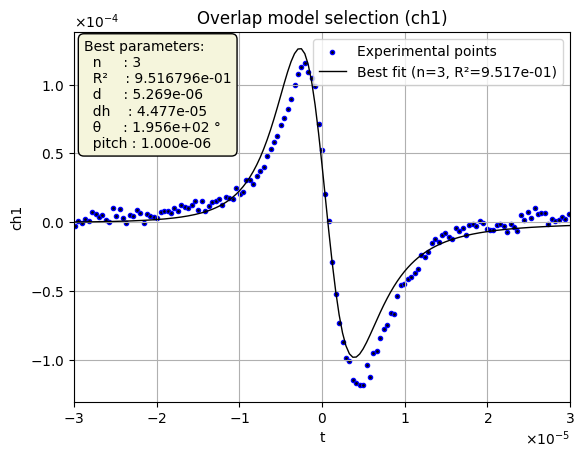


Best parameters:
  n     : 3
  R²    : 9.516796e-01
  d     : 5.269e-06
  dh    : 4.477e-05
  θ     : 1.956e+02 deg
  pitch : 1.000e-06

Selected best candidate:
  n     : 3
  R²    : 0.951680
  d     : 5.269e-06
  dh    : 4.477e-05
  theta : 3.413e+00
  pitch : 1.000e-06


In [170]:
# Select one dataframe to analyze
df_index = 38
df_plot1 = dfspkl[df_index].copy()

# Narrow time interval to isolate the peak
t_min, t_max = 272.92375, 272.92465
df_plot1 = df_plot1.loc[df_plot1["t"].between(t_min, t_max)].copy()

# Peak statistics (channel 1)
top_peak1 = df_plot1["ch1"].max()
bottom_peak1 = df_plot1["ch1"].min()

# Time at extrema (first occurrence)
t_bp1 = float(df_plot1.loc[df_plot1["ch1"].eq(bottom_peak1), "t"].iloc[0])
t_tp1 = float(df_plot1.loc[df_plot1["ch1"].eq(top_peak1), "t"].iloc[0])

# Time difference and derived displacement (domain-specific formula)
dt1 = t_bp1 - t_tp1
d_origin_peak1 = vavg * dt1 / 2

# Rebase time to start at zero
t = df_plot1["t"].to_numpy(copy=True)
t -= t[0]

# Center time around a reference sample, then convert to distance using vavg
center_idx = 99
if len(t) <= center_idx:
    raise ValueError(
        f"Filtered interval has {len(t)} samples, but center_idx={center_idx} was requested. "
        "Either widen the interval or choose a smaller center_idx."
    )

t = (t - t[center_idx]) * vavg

# Write back and reset index
df_plot1.loc[:, "t"] = t
df_plot1.index = np.arange(len(df_plot1), dtype=int)

# ------------------------------------------------------------
# Overlap-fit selection (n = 1..5) 
# ------------------------------------------------------------
PITCH = 1e-6
best = fit_overlaps_by_r2(
    df_plot1,
    x_col="t",
    y_col="ch1",
    n_range=range(1, 6),                 # test n = 1..5
    pitch=PITCH,
    p0=(5e-6, 50e-6, np.pi),             # (d, dh, theta)
    bounds=((0.0, -50e-6, 0.0), (1e-5, 50e-6, 2.0 * np.pi)),
    xlim=(-30e-6, 30e-6),
    title="Overlap model selection (ch1)",
    verbose=True,
)

# Best-fit parameters are available for downstream use
n_best = best["n"]
r2_best = best["r2"]
d_fit, dh_fit, theta_fit = best["popt"]

print(
    "\nSelected best candidate:\n"
    f"  n     : {n_best}\n"
    f"  R²    : {r2_best:.6f}\n"
    f"  d     : {d_fit:.3e}\n"
    f"  dh    : {dh_fit:.3e}\n"
    f"  theta : {theta_fit:.3e}\n"
    f"  pitch : {PITCH:.3e}"
)


R² comparison by n:
  n =  1  ->  R² = 8.741827e-01
  n =  2  ->  R² = 9.839714e-01
  n =  3  ->  R² = 9.496060e-01
  n =  4  ->  R² = 9.812091e-01
  n =  5  ->  R² = 9.604676e-01


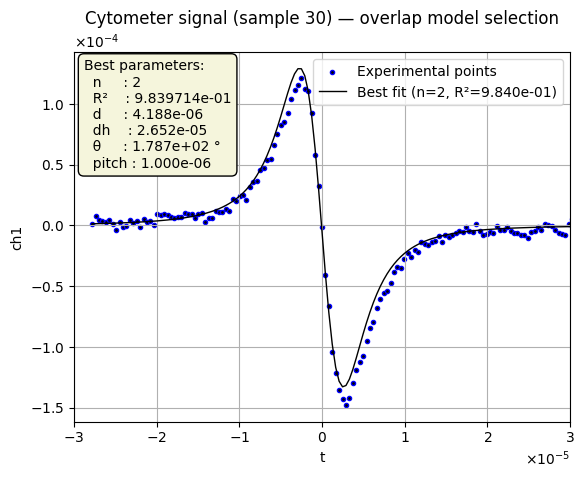


Best parameters:
  n     : 2
  R²    : 9.839714e-01
  d     : 4.188e-06
  dh    : 2.652e-05
  θ     : 1.787e+02 deg
  pitch : 1.000e-06

Selected best candidate:
  n     : 2
  R²    : 0.983971
  d     : 4.188e-06
  dh    : 2.652e-05
  theta : 3.118e+00
  pitch : 1.000e-06
  dt    : 6.500e-05
  d_origin_peak : 2.697e-06


In [171]:
# ------------------------------------------------------------
# Peak window selection + centering (sample 30)
# ------------------------------------------------------------
df_index = 30
t_min, t_max = 212.4828, 212.4835
center_idx = 67  # keep the same centering choice used before

df_plot = dfspkl[df_index].copy()
df_plot = df_plot.loc[df_plot["t"].between(t_min, t_max)].copy()

# Peak statistics (channel 1)
top_peak = df_plot["ch1"].max()
bottom_peak = df_plot["ch1"].min()

# Time at extrema (first occurrence)
t_bp = float(df_plot.loc[df_plot["ch1"].eq(bottom_peak), "t"].iloc[0])
t_tp = float(df_plot.loc[df_plot["ch1"].eq(top_peak), "t"].iloc[0])

# Derived displacement (domain-specific)
dt = t_bp - t_tp
d_origin_peak = vavg * dt / 2

# Rebase time to start at zero, then center around a reference sample and convert to distance
t = df_plot["t"].to_numpy(copy=True)
t -= t[0]

if len(t) <= center_idx:
    raise ValueError(
        f"Filtered interval has {len(t)} samples, but center_idx={center_idx} was requested. "
        "Either widen the interval or choose a smaller center_idx."
    )

df_plot.loc[:, "t"] = (t - t[center_idx]) * vavg
df_plot.index = np.arange(len(df_plot), dtype=int)


# ------------------------------------------------------------
# Overlap-fit selection (n = 1..5) using the helper function
# ------------------------------------------------------------
PITCH = 1e-6

best = fit_overlaps_by_r2(
    df_plot,
    x_col="t",
    y_col="ch1",
    n_range=range(1, 6),
    pitch=PITCH,
    p0=(5e-6, 0.0, np.pi),  # (d, dh, theta) following your original initial guess intent
    bounds=((0.0, -50e-6, 0.0), (1e-5, 50e-6, 2.0 * np.pi)),
    xlim=(-30e-6, 30e-6),
    title="Cytometer signal (sample 30) — overlap model selection",
    verbose=True,
)

n_best = best["n"]
r2_best = best["r2"]
d_fit, dh_fit, theta_fit = best["popt"]

print(
    "\nSelected best candidate:\n"
    f"  n     : {n_best}\n"
    f"  R²    : {r2_best:.6f}\n"
    f"  d     : {d_fit:.3e}\n"
    f"  dh    : {dh_fit:.3e}\n"
    f"  theta : {theta_fit:.3e}\n"
    f"  pitch : {PITCH:.3e}\n"
    f"  dt    : {dt:.3e}\n"
    f"  d_origin_peak : {d_origin_peak:.3e}"
)


R² comparison by n:
  n =  1  ->  R² = 8.055178e-01
  n =  2  ->  R² = 9.443961e-01
  n =  3  ->  R² = 9.582877e-01
  n =  4  ->  R² = 9.554797e-01
  n =  5  ->  R² = 9.509833e-01


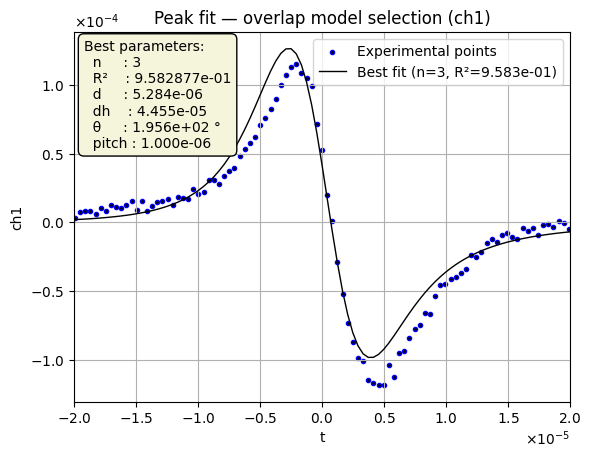


Best parameters:
  n     : 3
  R²    : 9.582877e-01
  d     : 5.284e-06
  dh    : 4.455e-05
  θ     : 1.956e+02 deg
  pitch : 1.000e-06
Selected best candidate:
  n     : 3
  R²    : 0.958288
  d     : 5.284e-06
  dh    : 4.455e-05
  theta : 3.413e+00
  pitch : 1.000e-06
  dt    : 8.500e-05
  d_origin_peak : 3.527e-06


In [172]:
# ------------------------------------------------------------
# Peak window selection + centering (sample 38)
# ------------------------------------------------------------
df_index = 38
t_min, t_max = 272.9240, 272.9245
center_idx = 49

df_plot5 = dfspkl[df_index].copy()
df_plot5 = df_plot5.loc[df_plot5["t"].between(t_min, t_max)].copy()

# Peak statistics (channel 1)
top_peak5 = df_plot5["ch1"].max()
bottom_peak5 = df_plot5["ch1"].min()

# Time at extrema (first occurrence)
t_bp5 = float(df_plot5.loc[df_plot5["ch1"].eq(bottom_peak5), "t"].iloc[0])
t_tp5 = float(df_plot5.loc[df_plot5["ch1"].eq(top_peak5), "t"].iloc[0])

# Time difference and derived displacement (domain-specific)
dt5 = t_bp5 - t_tp5
d_origin_peak5 = vavg * dt5 / 2

# Rebase to start at zero, center around reference index, convert using vavg
t5 = df_plot5["t"].to_numpy(copy=True)
t5 -= t5[0]

if len(t5) <= center_idx:
    raise ValueError(
        f"Filtered interval has {len(t5)} samples, but center_idx={center_idx} was requested. "
        "Either widen the interval or choose a smaller center_idx."
    )

df_plot5.loc[:, "t"] = (t5 - t5[center_idx]) * vavg
df_plot5.index = np.arange(len(df_plot5), dtype=int)


# ------------------------------------------------------------
# Overlap-fit selection (n = 1..5)
# ------------------------------------------------------------
PITCH = 1e-6

best = fit_overlaps_by_r2(
    df_plot5,
    x_col="t",
    y_col="ch1",
    n_range=range(1, 6),
    pitch=PITCH,
    p0=(5e-6, 0.0, np.pi), 
    bounds=((0.0, -50e-6, 0.0), (1e-5, 50e-6, 2.0 * np.pi)),
    xlim=(-20e-6, 20e-6),
    title="Peak fit — overlap model selection (ch1)",
    verbose=True,
)

n_best = best["n"]
r2_best = best["r2"]
d_fit, dh_fit, theta_fit = best["popt"]

# ------------------------------------------------------------
# Match your preferred print pattern
# ------------------------------------------------------------

print(
    "Selected best candidate:\n"
    f"  n     : {n_best}\n"
    f"  R²    : {r2_best:.6f}\n"
    f"  d     : {d_fit:.3e}\n"
    f"  dh    : {dh_fit:.3e}\n"
    f"  theta : {theta_fit:.3e}\n"
    f"  pitch : {PITCH:.3e}\n"
    f"  dt    : {dt5:.3e}\n"
    f"  d_origin_peak : {d_origin_peak5:.3e}"
)


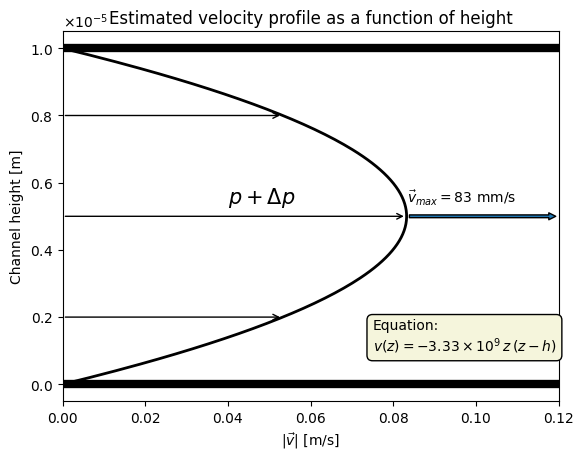

In [173]:
# ------------------------------------------------------------
# Estimated velocity profile vs channel height
# ------------------------------------------------------------
h = 10e-6                  # channel height [m]
v_fluid = vavg             # average fluid velocity [m/s]

a = vavg / (d_fit * (d_fit - h))


def v_profile(z):
    """Parabolic velocity profile: v(z) = a * z * (z - h)."""
    z = np.asarray(z, dtype=float)
    return a * z * (z - h)


# Height axis for plotting
z = np.linspace(0.0, h, 200)
v = v_profile(z)

x_plate = np.linspace(0.0, 0.15, 10)
y_bottom = np.zeros_like(x_plate)
y_top = np.full_like(x_plate, h)

plt.plot(x_plate, y_bottom, lw=6, color="black")
plt.plot(x_plate, y_top, lw=6, color="black")

# Velocity profile
plt.plot(v, z, lw=2, color="black")

# Formatting
plt.xlim(0.0, 0.12)
plt.title("Estimated velocity profile as a function of height")
plt.xlabel(r"$|\vec{v}|$ [m/s]")
plt.ylabel("Channel height [m]")
plt.ticklabel_format(style="sci", axis="y", scilimits=(0, 0), useMathText=True)

# ------------------------------------------------------------
# Annotations (computed from the profile instead of hard-coded)
# ------------------------------------------------------------
z_low, z_mid, z_high = 2e-6, 5e-6, 8e-6
v_low = float(v_profile(z_low))
v_mid = float(v_profile(z_mid))
v_high = float(v_profile(z_high))

# Arrows from 0 to v(z) at selected heights
plt.annotate("", xy=(v_high, z_high), xytext=(0.0, z_high),
             arrowprops=dict(facecolor="black", arrowstyle="->"))
plt.annotate("", xy=(v_low, z_low), xytext=(0.0, z_low),
             arrowprops=dict(facecolor="black", arrowstyle="->"))
plt.annotate("", xy=(v_mid, z_mid), xytext=(0.0, z_mid),
             arrowprops=dict(arrowstyle="->"))
plt.annotate("", xy=(0.12, z_mid), xytext=(v_mid, z_mid),
             arrowprops=dict(arrowstyle="simple"))

# Text labels
v_max = float(np.max(v))
plt.text(v_mid, z_mid + 0.4e-6, rf"$\vec{{v}}_{{max}}={v_max*1e3:.0f}$ mm/s", fontsize=10)
plt.text(0.04, z_mid + 0.4e-6, r"$p + \Delta p$", fontsize=15)

# Equation box
plt.text(
    x=0.075,
    y=0.1e-5,
    s=(
        "Equation:\n"
        r"$v(z) = -3.33 \times 10^{9}\, z\,(z-h)$"
    ),
    bbox=dict(
        facecolor="beige",
        edgecolor="black",
        boxstyle="round",
        pad=0.4
    ),
    fontsize=10
)
plt.show()
